In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import datetime 
import random
import pprint as pp

import numpy as np
np.random.seed( 42 )
random.seed(42)

In [39]:
totalReinit = False

In [4]:
if totalReinit:
    train = pd.read_csv('data/training_variants')
    trainingText = pd.read_csv('data/training_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)

    test = pd.read_csv('data/test_variants')
    testText = pd.read_csv('data/test_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)
    pid = test['ID'].values


In [185]:
## Consider adding these to stopwords:
crapWords = ['mutations',
 'cells',
 'variants',
 'fig',
 'et',
 'mutation',
 'cell',
 'figure',
 'cancer',
 'patients',
 'activity',
 'protein',
 'kinase',
 'mutant',
 'mutants',
 'domain',
 'expression',
 'using',
 'data',
 'also',
 'tumors',
 'analysis',
 'gene',
 'table',
 'activation',
 'supplementary',
 'deleterious',
 'may',
 'variant',
 'genes',
 'results',
 'resistance',
 'functional',
 'identified',
 'used',
 'shown',
 'proteins',
 'clinical',
 'signaling',
 'missense',
 'human',
 'one',
 'found',
 'study',
 'assay',
 'function',
 'lines',
 '10',
 'assays',
 'levels',
 'neutral',
 'cases',
 'treatment',
 'observed',
 'receptor',
 'three',
 'structure',
 'pathway',
 'sequence',
 'studies',
 'different',
 'patient',
 'showed',
 'samples',
 'inhibitors',
 'reported',
 'associated',
 'however']

In [5]:
if totalReinit:
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    # trainingText = trainingText.drop(['PText', 'PTextStem'], 1)
    def removeStopWordsAndStem(sentences):
        tokens = nltk.word_tokenize(sentences)
        tokens = [w.lower() for w in tokens if not w.lower()  in stop_words and  w.isalnum()]
        stemmed = [ps.stem(w) for w in tokens]

        return pd.Series({"PText": " ".join(tokens), "PTextStem": " ".join(stemmed)})

    trainingText = trainingText.join(trainingText.apply(lambda x : removeStopWordsAndStem(x['Text']), axis=1)) 
    testText = testText.join(testText.apply(lambda x : removeStopWordsAndStem(x['Text']), axis=1)) 

In [7]:
if totalReinit:
    trainingText.drop('Text', axis = 1)
    testText.drop('Text', axis = 1)
    trainingText.to_pickle('data/trainingTextStemmed')
    testText.to_pickle('data/testTextStemmed')

In [40]:
if totalReinit:
    trainingText = pd.read_pickle('data/trainingTextStemmed')
    testText = pd.read_pickle('data/testTextStemmed')
    train['PText'] = trainingText['PText']
    test['PText'] = testText['PText']
    train['PTextStem'] = trainingText['PTextStem']
    test['PTextStem'] = testText['PTextStem']
    train.to_pickle('data/trainStemmed')
    test.to_pickle('data/testStemmed')
    
textColumnNames = ['PText', 'PTextStem']

# LOAD directly merged, stemmed and without stop words train and test

In [10]:
if totalReinit == False:
    train = pd.read_pickle('data/trainStemmed')
    test = pd.read_pickle('data/testStemmed')

In [11]:
countVect = CountVectorizer()
wordCountPerDoc = countVect.fit_transform(train['PText'])
wordCountPerDoc

tTransformer = TfidfTransformer(smooth_idf=False)
tfidf = tTransformer.fit_transform(wordCountPerDoc)
tfidf = tfidf.toarray()
print(wordCountPerDoc.shape)
print(tfidf.shape)

(3321, 127153)
(3321, 127153)


In [12]:
def magicFrequency(countVect, tfidf, wordCountPerDoc) : 
    su = wordCountPerDoc.sum(axis=0).tolist()[0]
    sutf = tfidf.sum(axis=0).tolist()
    
    mostFrequentWords = [(word, su[idx], sutf[idx]) for word, idx in countVect.vocabulary_.items()]
    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])
    mostFrequentWordsTF = sorted(mostFrequentWords, key=lambda x : -x[2])
    
    return (mostFrequentWords,mostFrequentWordsTF)

_, x = magicFrequency(countVect, tfidf, wordCountPerDoc)

x[:50]

[('mutations', 236733, 274.4907684577915),
 ('cells', 183627, 178.12835920557563),
 ('brca1', 53994, 162.94035961770788),
 ('fig', 100215, 129.46513133754328),
 ('variants', 65651, 127.33355780379387),
 ('et', 104558, 124.31937698773373),
 ('mutation', 102326, 118.04403052599098),
 ('cell', 113764, 113.56470253847753),
 ('figure', 97375, 108.51551800563146),
 ('cancer', 90598, 104.37890685069246),
 ('pten', 28547, 100.41089359305718),
 ('patients', 85596, 97.14181381161107),
 ('egfr', 46606, 93.0504630856281),
 ('activity', 75865, 89.12051430945515),
 ('protein', 79558, 85.61517940119613),
 ('kinase', 60301, 85.20290100207838),
 ('p53', 34922, 83.64880509237469),
 ('mutant', 67266, 78.81600748811285),
 ('mutants', 52968, 76.38917173360004),
 ('domain', 63017, 74.61013666653668),
 ('tumor', 61974, 72.29159140433),
 ('expression', 75311, 72.22440508809602),
 ('using', 63491, 68.25668771801851),
 ('also', 66357, 67.10043851626936),
 ('tumors', 52409, 66.76552199929458),
 ('âˆ', 34011, 66.

In [41]:
vectorizers = {}
transformers = {}
tfidfs = {}
wordCounts = {}
mostPopularWords = {}
mostPopularWordsFreq = {}

for textModification in textColumnNames: # PText, PTextStem
    for c in train['Class'].unique():
        cn = textModification+str(c)
        print(cn)
        vectorizers[cn] = CountVectorizer()
        wordCounts[cn] = vectorizers[cn].fit_transform(train[train['Class']==c][textModification])

        transformers[cn] = TfidfTransformer(smooth_idf=False)
        tfidfs[cn] = transformers[cn].fit_transform(wordCounts[cn])
        tfidfs[cn] = tfidfs[cn].toarray()

        _, xx = magicFrequency(vectorizers[cn], tfidfs[cn],wordCounts[cn])
        mostPopularWords[cn] = [r[0] for r in xx]
        mostPopularWordsFreq[cn] = xx

PText1
PText2
PText3
PText4
PText5
PText6
PText7
PText8
PText9
PTextStem1
PTextStem2
PTextStem3
PTextStem4
PTextStem5
PTextStem6
PTextStem7
PTextStem8
PTextStem9


In [153]:
for textModification in textColumnNames: # PText, PTextStem
    for c in range(1,10):
        classWordCount = train[train['Class']==c][textModification].apply(len).sum()
        print(classWordCount)
        mostPopularWordsFreq[textModification+str(c)] = [(x[0],x[1],x[2],x[1]/classWordCount) for x in mostPopularWordsFreq[textModification+str(c)]]


24744044
19654905
2800436
28370648
8433287
8887734
50771907
976385
2240764
20993734
16691571
2381089
24070998
7140278
7508398
43102012
827024
1904433


In [45]:
intersect = {}
for textModification in textColumnNames: # PText, PTextStem
    intersect[textModification] = set(mostPopularWords[textModification+'1'])
    nbTopWords = 600
    for c in range(2,10):
        intersect[textModification] = intersect[textModification] & set(mostPopularWords[textModification+str(c)][:nbTopWords])
    print(len(intersect[textModification]))

194
219


In [186]:
print(intersect['PText'])

{'alleles', 'indicated', 'show', 'variants', 'based', '10', 'group', 'active', 'three', 'suggesting', 'within', 'type', 'formation', 'associated', 'proliferation', 'site', 'vivo', 'described', 'supplementary', 'although', 'many', 'therefore', 'tumors', 'signaling', 'changes', 'pcr', 'ability', 'detected', 'including', 'required', 'similar', 'growth', 'patients', 'loss', 'observed', 'examined', 'association', 'fig', '20', 'known', 'additional', 'results', 'high', 'table', 'mutants', 'function', 'functional', 'patient', 'respectively', 'would', 'transformation', 'kinase', 'analysis', 'total', 'sequence', 'breast', 'clinical', 'several', 'expressed', 'transcriptional', 'mutation', 'result', 'cancer', 'important', 'mutated', 'tyrosine', 'effect', 'experiments', 'inhibitors', 'assay', 'inhibitor', 'whether', 'first', 'reported', 'frequency', 'dna', 'either', 'number', 'less', 'treatment', 'new', 'samples', 'residues', 'mutant', 'protein', 'showed', 'found', 'shown', 'binding', 'cell', 'huma

In [194]:
for textModification in textColumnNames: # PText, PTextStem
    for c in range(1,10):
        mostPopularWordsFreq[textModification+str(c)] = [x for x in mostPopularWordsFreq[textModification+str(c)] if x[0] not in intersect['PText']]

In [46]:
len([x for x in set(mostPopularWords['PText3']) if x not in intersect['PText']])

12111

In [108]:
def frequentWordsByText(text) :
#     cleanText = getTerms(text)
    countVect = CountVectorizer()
    wordCountPerDoc = countVect.fit_transform([text])

    l = len(text)
    
    mostFrequentWords = [(word, wordCountPerDoc[0,idx]/l) for word, idx in countVect.vocabulary_.items()]

    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])

    return mostFrequentWords

frequentWordsByText(train['PText'][5])


[('mutations', 0.0050819894294619871),
 ('cbl', 0.0040994714730993361),
 ('binding', 0.0021683154899037808),
 ('cancer', 0.0021005556308442879),
 ('stability', 0.0013551971811898631),
 ('effects', 0.0011180376744816371),
 ('fig', 0.0010841577449518904),
 ('protein', 0.0010163978858923972),
 ('activity', 0.0010163978858923972),
 ('table', 0.00091475809730315761),
 ('state', 0.00088087816777341103),
 ('cells', 0.00088087816777341103),
 ('states', 0.00084699823824366445),
 ('proteins', 0.0007453584496544247),
 ('egfr', 0.0007453584496544247),
 ('damaging', 0.00071147852012467812),
 ('energy', 0.00071147852012467812),
 ('methods', 0.00067759859059493153),
 ('changes', 0.00064371866106518495),
 ('cell', 0.00060983873153543837),
 ('ubiquitination', 0.00060983873153543837),
 ('random', 0.00060983873153543837),
 ('mutant', 0.00060983873153543837),
 ('mutation', 0.00057595880200569179),
 ('figure', 0.00054207887247594521),
 ('mutants', 0.00054207887247594521),
 ('activation', 0.0005420788724759

In [143]:
for textModification in textColumnNames: # PText, PTextStem
#     train[textModification+'fw'] = train[textModification].apply(lambda x : [wordTuple[0] for wordTuple in frequentWordsByText(x)])
    train[textModification+'wf'] = train[textModification].apply(lambda x : [wordTuple for wordTuple in frequentWordsByText(x)])
    print('done train')
#     test[textModification+'fw'] = test[textModification].apply(lambda x : [wordTuple[0] for wordTuple in frequentWordsByText(x)])
    test[textModification+'wf'] = test[textModification].apply(lambda x : [wordTuple for wordTuple in frequentWordsByText(x)])
    print('done test')
    print(train[textModification+'fw'].head(5))

done train
done test
0    [cyclin, cdk10, fig, ets2, cells, expression, ...
1    [mutations, lung, cell, egfr, mutation, cells,...
2    [mutations, lung, cell, egfr, mutation, cells,...
3    [cbl, mutations, cases, aupd, upn, figure, mut...
4    [mutations, cbl, binding, cancer, stability, e...
Name: PTextfw, dtype: object
done train
done test
0    [cyclin, cdk10, cell, fig, express, protein, e...
1    [mutat, cell, lung, cancer, egfr, sampl, met, ...
2    [mutat, cell, lung, cancer, egfr, sampl, met, ...
3    [mutat, cbl, case, cell, aupd, upn, figur, ana...
4    [mutat, cbl, bind, activ, cancer, protein, sta...
Name: PTextStemfw, dtype: object


In [144]:
train[textModification+'fw'] = train[textModification+'wf'].apply(lambda x: x[0])
test[textModification+'fw'] = test[textModification+'wf'].apply(lambda x: x[0])
    

In [196]:
def wordFrequencyForCat(wf, catWordFreq):
    f = [w for w in wf if w[0] in list(zip(*catWordFreq))[0]]
    dictF = dict(f)
#     print(dictF)
    
    wff = [(w[0], dictF.get(w[0],0), w[3]) for w in catWordFreq]
    v1= np.array(list(zip(*wff))[1])
    v2= np.array(list(zip(*wff))[2])
    
    x = abs(v1-v2)
#     print(v1, v2)
    return wff, np.mean(x)*1e6, np.std(x)*1e6, x
    
train.head(5)

mostPopularWordsFreq['PText1'][0]

r =  [('cyclin',0.001),('cell',0.004), ('azeazeaeaze',0.03)]

sample = 1

for sample in range(3,5):
    for c in range(1,10):
        ret = wordFrequencyForCat(train['PTextwf'][sample],mostPopularWordsFreq['PText'+str(c)][:500])
        print("class %s: %s %s" % (c, ret[1], ret[2]))
    # print( ret[0])
    # print( ret[3])

    xxxxx = input()

    print( train['Class'][sample])
# pp.pprint(ret)

# train[train['Class']==1]['PText'].apply(len).sum()


# mostPopularWordsFreq['PTextStem7'][:100]

class 1: 59.876008132 82.6909236508
class 2: 69.4183987942 94.041518464
class 3: 84.322795668 213.616485518
class 4: 71.6505226022 184.192216982
class 5: 76.2814104099 191.804788895
class 6: 81.6961954993 213.914263031
class 7: 66.4769058744 90.830615154
class 8: 67.7004070176 86.6604016746
class 9: 78.3453474538 109.395056104
1
3
class 1: 61.5702166503 89.4300286874
class 2: 61.6693956421 71.9477639636
class 3: 78.6177998062 210.942612496
class 4: 76.0483224047 206.955994442
class 5: 77.3709130969 211.846996209
class 6: 85.5504135265 234.901775387
class 7: 62.6039948342 69.781403854
class 8: 65.8563967355 72.656380946
class 9: 77.6665054986 112.89171449
2
4


In [48]:
nboverlap = 250

def overlapRange(fw, overlapSize, popularWords):
    n = len(list(set(fw[:overlapSize]) & set(popularWords)))
    return float(n)/overlapSize
    
for textModification in textColumnNames: # PText, PTextStem
    for nboverlap in range(20,301,20):
        for i in range(1, 10):
            columnName = textModification + 'Overlap' + str(nboverlap) + 'C' + str(i)
            ignoreWords = []
            popularWords=[w for w in mostPopularWords[textModification + str(i)] if w not in ignoreWords][:nboverlap]

            train[columnName] = train[textModification + 'fw'].apply(lambda x: overlapRange(x,  nboverlap, popularWords))
            test[columnName] = test[textModification + 'fw'].apply(lambda x: overlapRange(x, nboverlap, popularWords))
            print(columnName)


PTextOverlap20C1
PTextOverlap20C2
PTextOverlap20C3
PTextOverlap20C4
PTextOverlap20C5
PTextOverlap20C6
PTextOverlap20C7
PTextOverlap20C8
PTextOverlap20C9
PTextOverlap40C1
PTextOverlap40C2
PTextOverlap40C3
PTextOverlap40C4
PTextOverlap40C5
PTextOverlap40C6
PTextOverlap40C7
PTextOverlap40C8
PTextOverlap40C9
PTextOverlap60C1
PTextOverlap60C2
PTextOverlap60C3
PTextOverlap60C4
PTextOverlap60C5
PTextOverlap60C6
PTextOverlap60C7
PTextOverlap60C8
PTextOverlap60C9
PTextOverlap80C1
PTextOverlap80C2
PTextOverlap80C3
PTextOverlap80C4
PTextOverlap80C5
PTextOverlap80C6
PTextOverlap80C7
PTextOverlap80C8
PTextOverlap80C9
PTextOverlap100C1
PTextOverlap100C2
PTextOverlap100C3
PTextOverlap100C4
PTextOverlap100C5
PTextOverlap100C6
PTextOverlap100C7
PTextOverlap100C8
PTextOverlap100C9
PTextOverlap120C1
PTextOverlap120C2
PTextOverlap120C3
PTextOverlap120C4
PTextOverlap120C5
PTextOverlap120C6
PTextOverlap120C7
PTextOverlap120C8
PTextOverlap120C9
PTextOverlap140C1
PTextOverlap140C2
PTextOverlap140C3
PTextOverl

In [49]:
for textModification in textColumnNames: # PText, PTextStem
    for nboverlap in range(20,301,20):
        for i in range(1, 10):
            columnName = textModification + 'OverlapIntersect' + str(nboverlap) + 'C' + str(i)
            ignoreWords = intersect[textModification]
            popularWords=[w for w in mostPopularWords[textModification + str(i)] if w not in ignoreWords][:nboverlap]

            train[columnName] = train[textModification + 'fw'].apply(lambda x: overlapRange(x,  nboverlap, popularWords))
            test[columnName] = test[textModification + 'fw'].apply(lambda x: overlapRange(x, nboverlap, popularWords))
            print(columnName)



PTextOverlapIntersect20C1
PTextOverlapIntersect20C2
PTextOverlapIntersect20C3
PTextOverlapIntersect20C4
PTextOverlapIntersect20C5
PTextOverlapIntersect20C6
PTextOverlapIntersect20C7
PTextOverlapIntersect20C8
PTextOverlapIntersect20C9
PTextOverlapIntersect40C1
PTextOverlapIntersect40C2
PTextOverlapIntersect40C3
PTextOverlapIntersect40C4
PTextOverlapIntersect40C5
PTextOverlapIntersect40C6
PTextOverlapIntersect40C7
PTextOverlapIntersect40C8
PTextOverlapIntersect40C9
PTextOverlapIntersect60C1
PTextOverlapIntersect60C2
PTextOverlapIntersect60C3
PTextOverlapIntersect60C4
PTextOverlapIntersect60C5
PTextOverlapIntersect60C6
PTextOverlapIntersect60C7
PTextOverlapIntersect60C8
PTextOverlapIntersect60C9
PTextOverlapIntersect80C1
PTextOverlapIntersect80C2
PTextOverlapIntersect80C3
PTextOverlapIntersect80C4
PTextOverlapIntersect80C5
PTextOverlapIntersect80C6
PTextOverlapIntersect80C7
PTextOverlapIntersect80C8
PTextOverlapIntersect80C9
PTextOverlapIntersect100C1
PTextOverlapIntersect100C2
PTextOverl

In [140]:
nboverlap = 250

def wordDeviation(fw, popularWords):
    diff = fw - popularWords
    sd = 
    return sum(diff)/len(diff)
    
for textModification in textColumnNames: # PText, PTextStem
    for nboverlap in range(20,301,20):
        for i in range(1, 10):
            columnName = textModification + 'Overlap' + str(nboverlap) + 'C' + str(i)
            ignoreWords = []
            popularWords=[w for w in mostPopularWords[textModification + str(i)] if w not in ignoreWords][:nboverlap]
            fw =

            train[columnName] = train[textModification + 'fw'].apply(lambda x: overlapRange(x,  nboverlap, popularWords))
            test[columnName] = test[textModification + 'fw'].apply(lambda x: overlapRange(x, nboverlap, popularWords))
            print(columnName)



['overlapIntersect50C1',
 'overlapIntersect50C2',
 'overlapIntersect50C3',
 'overlapIntersect50C4',
 'overlapIntersect50C5',
 'overlapIntersect50C6',
 'overlapIntersect50C7',
 'overlapIntersect50C8',
 'overlapIntersect50C9',
 'overlapIntersect100C1',
 'overlapIntersect100C2',
 'overlapIntersect100C3',
 'overlapIntersect100C4',
 'overlapIntersect100C5',
 'overlapIntersect100C6',
 'overlapIntersect100C7',
 'overlapIntersect100C8',
 'overlapIntersect100C9',
 'overlapIntersect150C1',
 'overlapIntersect150C2',
 'overlapIntersect150C3',
 'overlapIntersect150C4',
 'overlapIntersect150C5',
 'overlapIntersect150C6',
 'overlapIntersect150C7',
 'overlapIntersect150C8',
 'overlapIntersect150C9',
 'overlapIntersect200C1',
 'overlapIntersect200C2',
 'overlapIntersect200C3',
 'overlapIntersect200C4',
 'overlapIntersect200C5',
 'overlapIntersect200C6',
 'overlapIntersect200C7',
 'overlapIntersect200C8',
 'overlapIntersect200C9',
 'overlapIntersect250C1',
 'overlapIntersect250C2',
 'overlapIntersect250

In [146]:
train.to_pickle('data/trainAuu')
test.to_pickle('data/testAuu')

In [4]:
train = pd.read_pickle('data/trainAuu')
test = pd.read_pickle('data/testAuu')

In [21]:
features=['overlap100C'+str(c) for c in range(1, 10)]
train[features][:1]

,overlap100C1,overlap100C2,overlap100C3,overlap100C4,overlap100C5,overlap100C6,overlap100C7,overlap100C8,overlap100C9
0,0.33,0.34,0.31,0.33,0.31,0.27,0.36,0.28,0.28


In [56]:
train.columns


Index(['ID', 'Gene', 'Variation', 'Class', 'PText', 'PTextStem', 'fw',
       'overlap20C1', 'overlap20C2', 'overlap20C3',
       ...
       'PTextStemOverlapIntersect280C9', 'PTextStemOverlapIntersect300C1',
       'PTextStemOverlapIntersect300C2', 'PTextStemOverlapIntersect300C3',
       'PTextStemOverlapIntersect300C4', 'PTextStemOverlapIntersect300C5',
       'PTextStemOverlapIntersect300C6', 'PTextStemOverlapIntersect300C7',
       'PTextStemOverlapIntersect300C8', 'PTextStemOverlapIntersect300C9'],
      dtype='object', length=819)

In [67]:
genes = set(train['Gene'])
genes = genes.union(test['Gene'])
genes = list(genes)
geneDummies = pd.get_dummies(genes)

trainWithGenes = train.join(geneDummies)
testWithGenes = test.join(geneDummies)

In [14]:
# features=['overlap250C'+str(c) for c in range(1, 10)]
#features.extend(geneDummies.columns)
features

['overlap20C1',
 'overlap20C2',
 'overlap20C3',
 'overlap20C4',
 'overlap20C5',
 'overlap20C6',
 'overlap20C7',
 'overlap20C8',
 'overlap20C9',
 'overlap40C1',
 'overlap40C2',
 'overlap40C3',
 'overlap40C4',
 'overlap40C5',
 'overlap40C6',
 'overlap40C7',
 'overlap40C8',
 'overlap40C9',
 'overlap60C1',
 'overlap60C2',
 'overlap60C3',
 'overlap60C4',
 'overlap60C5',
 'overlap60C6',
 'overlap60C7',
 'overlap60C8',
 'overlap60C9',
 'overlap80C1',
 'overlap80C2',
 'overlap80C3',
 'overlap80C4',
 'overlap80C5',
 'overlap80C6',
 'overlap80C7',
 'overlap80C8',
 'overlap80C9',
 'overlap100C1',
 'overlap100C2',
 'overlap100C3',
 'overlap100C4',
 'overlap100C5',
 'overlap100C6',
 'overlap100C7',
 'overlap100C8',
 'overlap100C9',
 'overlap120C1',
 'overlap120C2',
 'overlap120C3',
 'overlap120C4',
 'overlap120C5',
 'overlap120C6',
 'overlap120C7',
 'overlap120C8',
 'overlap120C9',
 'overlap140C1',
 'overlap140C2',
 'overlap140C3',
 'overlap140C4',
 'overlap140C5',
 'overlap140C6',
 'overlap140C7',

In [68]:
def gboost1(df, df_test, features):
    print('\n##################\nXGBoost\n##################')
    param = {}
    # param['booster'] = 'gbtree'
    #param['objective'] = 'binary:logistic'
    # param["eval_metric"] = "error"
    # param['eta'] = 0.3
    # param['gamma'] = 0
    param['max_depth'] = 6
    param['n_estimators'] = 200
    param['learning_rate'] = 0.1
    param['seed'] = 42
    # param['min_child_weight'] = 1
    # param['max_delta_step'] = 0
    # param['subsample'] = 1
    # param['colsample_bytree'] = 1
    # param['silent'] = 1
    # param['seed'] = 0
    # param['base_score'] = 0.4

    estimator = XGBClassifier()
    estimator.set_params(**param)
    x1, x2, y1, y2 = model_selection.train_test_split(df[features], df['Class'], test_size=0.2)
    calibratedCV = CalibratedClassifierCV(estimator, method='sigmoid', cv=5)
    calibratedCV.fit(x1, y1)
    prediction = calibratedCV.predict(x2)
    
#     print(calibratedCV.best_estimator_.booster())
#     print(calibratedCV.calibrated_classifiers_)
#     for c in calibratedCV.calibrated_classifiers_:
#         print(c.feature_importances_)
#         plot_importance(c)
#         pyplot.show()
#     feat_imp = pd.Series(calibratedCV.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title = 'Feature imp')
#     estimator.fit(x1, y1)
#     prediction = estimator.predict(x2)
#     xgb.plot_importance(estimator, max_num_features = 50)
#     imp = estimator.feature_importances_
#     plot_importance(estimator)
#     pyplot.show()

    acc = np.mean(prediction == y2)
    print('accuracy %s %s' % (acc, prediction[:5]))
    result = calibratedCV.predict(df_test[features])
#     result = estimator.predict(test)
#     return (imp, result)
    return result, acc



prediction, _ = gboost1(train,test , allFeatures)
# prediction, _ = gboost1(train,test , intersectFeatures)
#prediction = gboost1(trainWithGenes,testWithGenes, features)



##################
XGBoost
##################
accuracy 0.613533834586 [4 2 1 7 1]


In [59]:
features = []

for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextOverlap' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction, _ = gboost1(train,test , features) # 0.633082706767 


##################
XGBoost
##################
accuracy 0.631578947368 [4 4 1 7 2]


In [60]:
features = []

for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextStemOverlap' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction, _ = gboost1(train,test , features)


##################
XGBoost
##################
accuracy 0.628571428571 [1 4 7 5 7]


In [27]:
features = []
for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextOverlapIntersect' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction,_ = gboost1(train,test , features)


##################
XGBoost
##################
accuracy 0.646616541353 [7 7 4 6 7]


In [65]:
features = []
for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextStemOverlapIntersect' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction,_ = gboost1(train,test , features) #0.625563909774 


##################
XGBoost
##################
accuracy 0.618045112782 [7 4 4 4 1]


In [63]:
features = []
for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextOverlapIntersect' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
        columnName = 'PTextOverlap' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction,_ = gboost1(train,test ,features )



##################
XGBoost
##################


KeyboardInterrupt: 

In [ ]:
features = []
for nboverlap in range(20,301,20):
    for i in range(1, 10):
        columnName = 'PTextStemOverlapIntersect' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
        columnName = 'PTextStemOverlap' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
prediction,_ = gboost1(train,test ,features )

In [33]:
p = {}
pi = {}

for nboverlap in range(20,301,20):
    features = []
    for i in range(1, 10):
        columnName = 'overlap' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
    _, acc = gboost1(train,test , features)
    print('overlap' + str(nboverlap))
    p['overlap' + str(nboverlap)] = acc

for nboverlap in range(20,301,20):
    features = []
    for i in range(1, 10):
        columnName = 'overlapIntersect' + str(nboverlap) + 'C'+str(i)
        features.append(columnName)
    _, acc = gboost1(train,test , features)
    print('overlapIntersect' + str(nboverlap))
    pi['overlapIntersect' + str(nboverlap)] = acc



##################
XGBoost
##################
accuracy 0.589473684211 [7 1 7 7 6]
overlap20

##################
XGBoost
##################
accuracy 0.571428571429 [7 6 4 4 4]
overlap40

##################
XGBoost
##################
accuracy 0.583458646617 [1 1 2 5 2]
overlap60

##################
XGBoost
##################
accuracy 0.583458646617 [7 7 4 4 2]
overlap80

##################
XGBoost
##################
accuracy 0.572932330827 [1 5 1 4 2]
overlap100

##################
XGBoost
##################
accuracy 0.604511278195 [4 1 7 7 4]
overlap120

##################
XGBoost
##################
accuracy 0.571428571429 [7 7 4 1 4]
overlap140

##################
XGBoost
##################
accuracy 0.607518796992 [7 7 7 1 4]
overlap160

##################
XGBoost
##################
accuracy 0.596992481203 [7 2 6 1 4]
overlap180

##################
XGBoost
##################
accuracy 0.615037593985 [4 1 6 7 4]
overlap200

##################
XGBoost
##################
accuracy 0.613533

In [54]:
sorted(p)
pi

{'overlapIntersect100': 0.58796992481203003,
 'overlapIntersect120': 0.61954887218045118,
 'overlapIntersect140': 0.60601503759398501,
 'overlapIntersect160': 0.59548872180451129,
 'overlapIntersect180': 0.61804511278195484,
 'overlapIntersect20': 0.51127819548872178,
 'overlapIntersect200': 0.60300751879699244,
 'overlapIntersect220': 0.62406015037593987,
 'overlapIntersect240': 0.59398496240601506,
 'overlapIntersect260': 0.63007518796992479,
 'overlapIntersect280': 0.60751879699248124,
 'overlapIntersect300': 0.64962406015037599,
 'overlapIntersect40': 0.5759398496240602,
 'overlapIntersect60': 0.55488721804511276,
 'overlapIntersect80': 0.5909774436090226}

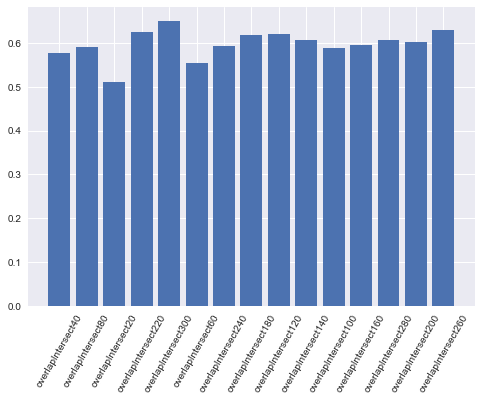

In [53]:
# plt.plot(p)
# plt.plot(p.values().value)
# plt.figsize(18,8)
plt.bar(range(len(p)), pi.values(), align='center')
plt.xticks(range(len(p)), pi.keys(), rotation=60)
plt.show()

In [19]:
features

['overlap50C1',
 'overlap50C2',
 'overlap50C3',
 'overlap50C4',
 'overlap50C5',
 'overlap50C6',
 'overlap50C7',
 'overlap50C8',
 'overlap50C9',
 'overlap100C1',
 'overlap100C2',
 'overlap100C3',
 'overlap100C4',
 'overlap100C5',
 'overlap100C6',
 'overlap100C7',
 'overlap100C8',
 'overlap100C9',
 'overlap150C1',
 'overlap150C2',
 'overlap150C3',
 'overlap150C4',
 'overlap150C5',
 'overlap150C6',
 'overlap150C7',
 'overlap150C8',
 'overlap150C9',
 'overlap200C1',
 'overlap200C2',
 'overlap200C3',
 'overlap200C4',
 'overlap200C5',
 'overlap200C6',
 'overlap200C7',
 'overlap200C8',
 'overlap200C9',
 'overlap250C1',
 'overlap250C2',
 'overlap250C3',
 'overlap250C4',
 'overlap250C5',
 'overlap250C6',
 'overlap250C7',
 'overlap250C8',
 'overlap250C9']

In [113]:
test.columns

Index(['ID', 'Gene', 'Variation', 'PText', 'fw', 'overlap250C1',
       'overlap250C2', 'overlap250C3', 'overlap250C4', 'overlap250C5',
       'overlap250C6', 'overlap250C7', 'overlap250C8', 'overlap250C9'],
      dtype='object')

In [57]:
def submission(prediction):
    onehot = pd.get_dummies(prediction)
    submission = pd.DataFrame()
    submission['ID'] = test['ID']
    submission = submission.join(onehot)
    submission.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
    now = datetime.datetime.now()
    date_string = now.strftime('%Y-%m-%d-%I-%M')
    submission.to_csv('output/' + date_string + 'submission_xgb.csv', index=False)
submission(prediction)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


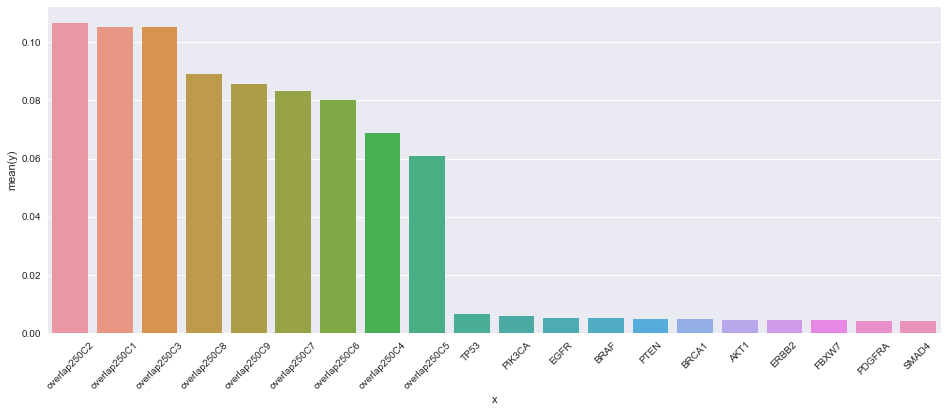

In [22]:
xgboostImp.shape
len(features)
xgboostFeatureImp = pd.DataFrame()
xgboostFeatureImp['x'] = features
xgboostFeatureImp['y'] = xgboostImp
xgboostFeatureImp = xgboostFeatureImp.sort(['y'], ascending = 0)
plt.figure(figsize = (16, 6))
plt.xticks(rotation=45)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[:20])
plt.show()
plt.figure(figsize = (16, 6))
plt.xticks(rotation=90)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[-140:])


In [24]:
len(features)

273